# Day 3 part 1: Stochastic models

In [1]:
knitr::opts_chunk$set(echo = TRUE)

In this practical we will apply some of the concepts about stochasticity, epidemic persistence and fade out probability. With that aim in mind we will start by exploring the binomial distribution, and how can we sample from a distribution in R.

## Why we need the binomial distribution?

In statistics and probability theory, we tend to associate certain even characteristics with a statistical distribution. We can say confidently for example, that the population body weight follows a Normal distribution. The normal distribution is continuous (your weight can be 74Kg or 74.37kg and be part of the distribution), and is defined by a mean and a standard deviation, which reflects the central measure and the spread of the data. For example, we say:

$$
Weight \sim Normal(72.5,5)  
$$

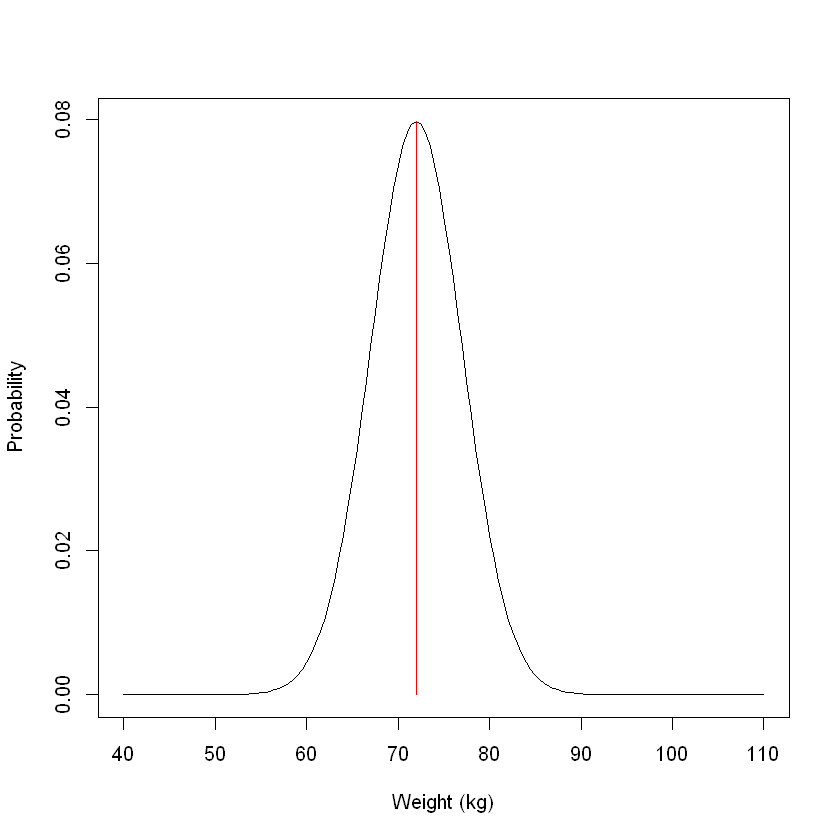

In [8]:
x <- seq(40, 110, by = .5)

y <- dnorm(x, mean = 72, sd = 5)

plot(x,y,type = "l", xlab = "Weight (kg)", ylab = "Probability")
lines(c(72,72),c(0,max(y)),col="red")


The Binomial distribution on the other hand, is a discrete probability distribution of the number of successes in a sequence of experiments. Think about flipping a coin several times and counting the number of times you will get heads as a result. The Binomial distribution takes parameters *n* (number of trials), and *p* (probability of success). If we keep with our example of tossing a coin, we can say that if the coin is fair, the probability of success (get heads) is 50%. This means that if we toss the coin enough times the count of successes should approach 50%.

Importantly, when we speak of binomial experiments of 1 trial (tossing the coin just once) we speak of *Bernoulli* trials. For trials \> 1 we speak of the binomial distribution.

Let us try this using R. In R, the base function *rbinom* is used to calculate this type of experiments. *rbinom* takes parameters *n* for number of observations, *size* for number of trials, and *prob* for probability of success. Run the code below:

In [9]:
# Let's toss the coin once (Bernoulli)
rbinom(n=1,size=1,prob=0.5)

# Now let's try 100 trials
rbinom(n=1,size=100,prob=0.5)

[1] 1

[1] 42

a)  How many successes you got when tossing the coin 100 times?

b)  What happens if you increase your number of trials?

**Answer: The estimate is much closer to 50% (increase in sample size)**

But let's examine a case more relevant for this course. Now that you know the binomial distribution, you can see how the binomial probability is relevant for the process of infection transmission. So far, we learnt in our previous lectures that transmission depends on at least three factors:

The transmission probability $$\beta $$, the prevalence of infection $$\frac{I}{N} $$, and duration of infectious period $$D $$.

As we examined before, the number of new infections (*Y*) at any point in time can be described by: $$
Y = S\frac{\beta I}{N}
$$ Where *S* is the number of susceptible individuals. In a deterministic view, as long as our variables and parameters are the same, this will always produce the same number. But as we learnt before, the process of infection involves randomness.

To bring back the *Binomial* trials, we can see how we can fit our process of infection in this framework. At a given point, if the prevalence of infection is say, 10% and we know that *beta* = 0.2, we can say that the probability of infection is 0.1 x 0.2. The number of trials in this distribution is the number of susceptible. Try to adapt the code below to predict the number of infections accounting for stochastic events:

In [10]:
# Define our parameters
R0 <- 2     # Basic reproduction number
gamma<- 0.1 # recovery rate
beta<-  0.2 # <- can you figure out beta from the R0 formula?
prevalence <- 0.1 # Prevalence of infection (I/N)
S <- 1000 # Susceptible individuals at time t  

n_trials <- S
probability_of_infection<-beta * prevalence 

# Draw from the binomial distribution to predict number of new infections Y 
Y<-rbinom(n=1,size= n_trials ,prob=probability_of_infection)  


**Answer: The predicted number of infections is \~14 (it will vary as it is a stochastic process)**

Now that we have a better idea of how stochasticity in the infection process can be expressed with simple R commands, let's try formulating a stochastic model.

### *Technical Parenthesis:*

Stochastic model can be coded with different approached in R. We will use a package called *Odin*. Other packages or even base R can be used for this purpose, but I believe *Odin* gives us a very neat view of the construction of discrete stochastic process (see [here](https://mrc-ide.github.io/odin/index.html) for further information on Odin package). To install *Odin* copy and paste the following code in your script. Once installed you can erase or comment this code (you only need to install once).

In [11]:

if (!require("drat")) install.packages("drat")
drat:::add("mrc-ide")
install.packages("dde")
install.packages("odin")


Installing package into 'C:/Users/juano/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)

Warning message:
"unable to access index for repository https://mrc-ide.github.io/drat/bin/windows/contrib/4.3:
  cannot open URL 'https://mrc-ide.github.io/drat/bin/windows/contrib/4.3/PACKAGES'"


package 'dde' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\juano\AppData\Local\Temp\RtmpaOSjjH\downloaded_packages


Warning message:
"package 'odin' is in use and will not be installed"


The process might take a few minutes, after that, you can call the *odin* package in the usual form:

In [6]:

library(odin)


## Formulating a stochastic model

A new viral disease (disease "X") has been identified in your community. From surveillance data collected so far a few parameters have been estimated. An initial R0 has been estimated at \~ 2, and the time from onset of symptoms to recovery has a mean of 8 days. It has also been noted in previous outbreaks of disease "X" that acquired immunity through infection has a median life of 3 months .

The code below defines an SIR stochastic model. 1. Try to fill the gaps (marked with the *??* symbol), and pay attention at how stochastic events are incorporated in the infection process:

In [13]:

library(odin)
library(ggplot2)
library(reshape2)

sir_generator <- odin::odin({
  ## Core equations for transitions between compartments:
  update(S) <- S - n_SI + n_RS # Susceptible
  update(I) <- I + n_SI - n_IR # Infectious
  update(R) <- R + n_IR - n_RS # Recovered
  
  ## Individual probabilities of transition:
  p_SI <- 1 - exp(-beta * I / N) # S to I
  p_IR <- 1 - exp(-gamma)        # I to R
  p_RS <- 1 - exp(-delta)        # R to S
  
  ## Draw from binomial distributions to define numbers changing between compartments:
  n_SI <- rbinom(S, p_SI) # New infections
  n_IR <- rbinom(I, p_IR) # New recovered 
  n_RS <- rbinom(R, p_RS) # New losing immunity 
  
  ## Total population size
  N <- S + I + R
  
  # Define beta in R0 terms
  beta <- R0 * gamma #<------------------------- Can you define beta in terms of R0? 

  ## Initial states:
  initial(S) <- S_ini
  initial(I) <- I_ini
  initial(R) <- 0
  
  ## User defined parameters - default in parentheses:
  S_ini <- user()
  I_ini <- user()
  R0    <- user()
  gamma <- user()
  delta <- user()
  
}, verbose = FALSE)


If you filled the gaps with the question marks, now,

2.  Define the model parameters and run your model to see the results.

Once you have run your model, you should see plot now.

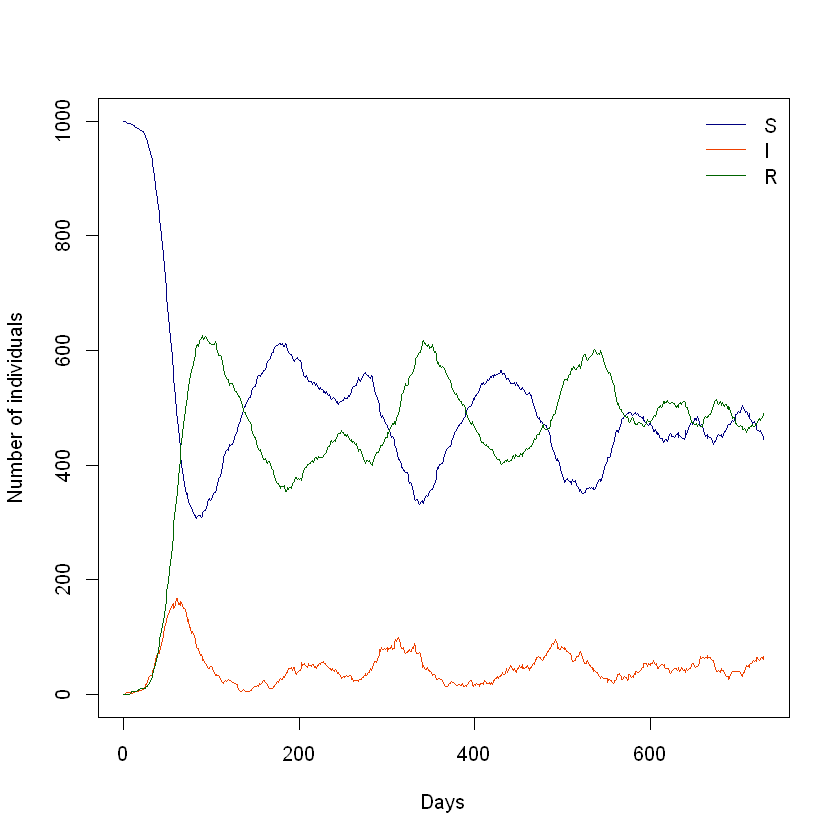

In [15]:
# Define parameters 
R0   <- 2 # R0  
gamma<- 1/8 # recovery rate
delta<- 1/90 # Immunity loss rate 
S0   <- 1000 # Susceptible population at time 0
I0   <- 1    # Infectious population at time 0

    
# Create a model object "sir" with the defined parameters   
sir <- sir_generator$new(
  S_ini = S0,
  I_ini = I0,
  R0    = R0,
  gamma = gamma,
  delta = delta)

# Set the seed for radom number generation (R standard)
set.seed(1)

# Run our SIR model for a period of two years (in day steps)
t_end<- 365 * 2
sir_res <- sir$run(0:t_end)

#Plot our model

sir_col <- c("Navyblue", "orangered2", "darkgreen") # Plot colours

days <- sir_res[, 1] # define time vector for our plot 

matplot(days, sir_res[, -1], xlab = "Days", ylab = "Number of individuals",
        type = "l", col = sir_col, lty = 1)
legend("topright", lwd = 1, col = sir_col, legend = c("S", "I", "R"), bty = "n")


Given that we introduced a stochastic process, every model run will be different. Try running this same code several times to see how results vary.

Form our lecture on epidemic persistence, you might remember that we can roughly estimate a threshold under which the probability of extinction becomes more likely.

3.  Try to define that threshold in the code below, and plot your model again to see your infections plotted against this threshold

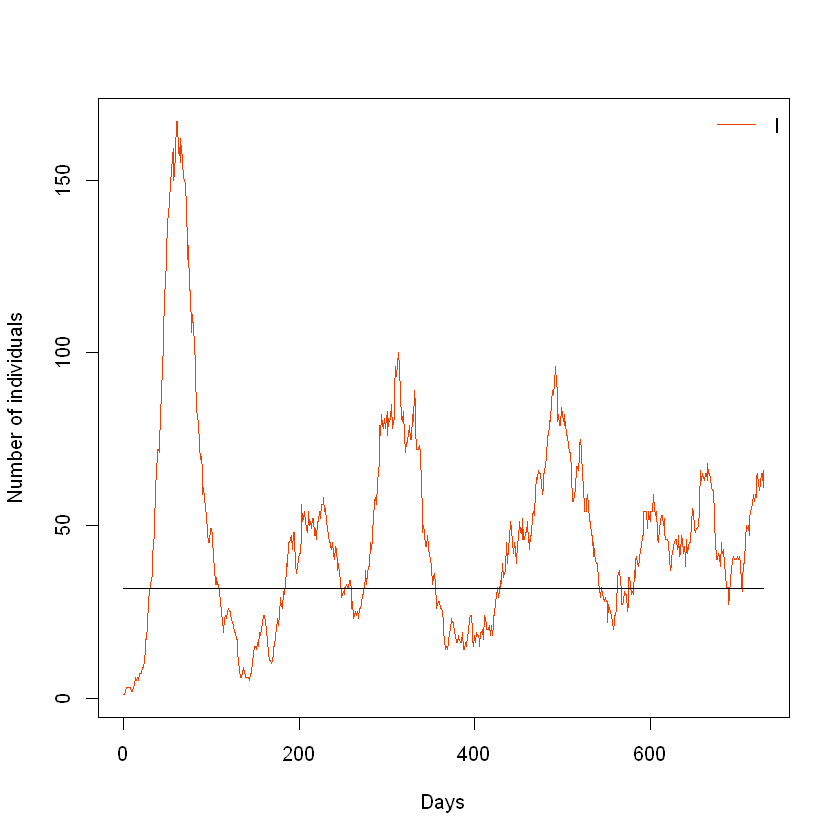

In [16]:
# Define a threshold

Y_limit <- sqrt(1001) # Hint look at lecture slides for how 

#Plot our model

sir_col <- c("Navyblue", "orangered2", "darkgreen") # Plot colours

days <- sir_res[, 1] # define time vector for our plot 

matplot(days, sir_res[, 3], xlab = "Days", ylab = "Number of individuals",
        type = "l", col = "orangered2", lty = 1)
lines(c(0,365*2),c(Y_limit,Y_limit), col="black")
legend("topright", lwd = 1, col = "Orangered2", legend = c("I"), bty = "n")


4.  What can you tell about the trend of infections over time?

    **Answer: Infections have a large initial peak and subsequent smaller peaks**

5.  Try reproducing this analysis for a value of R0 = 1.1 and for R0 = 4. What do you observe?
    **Answer: For R0=1.1**

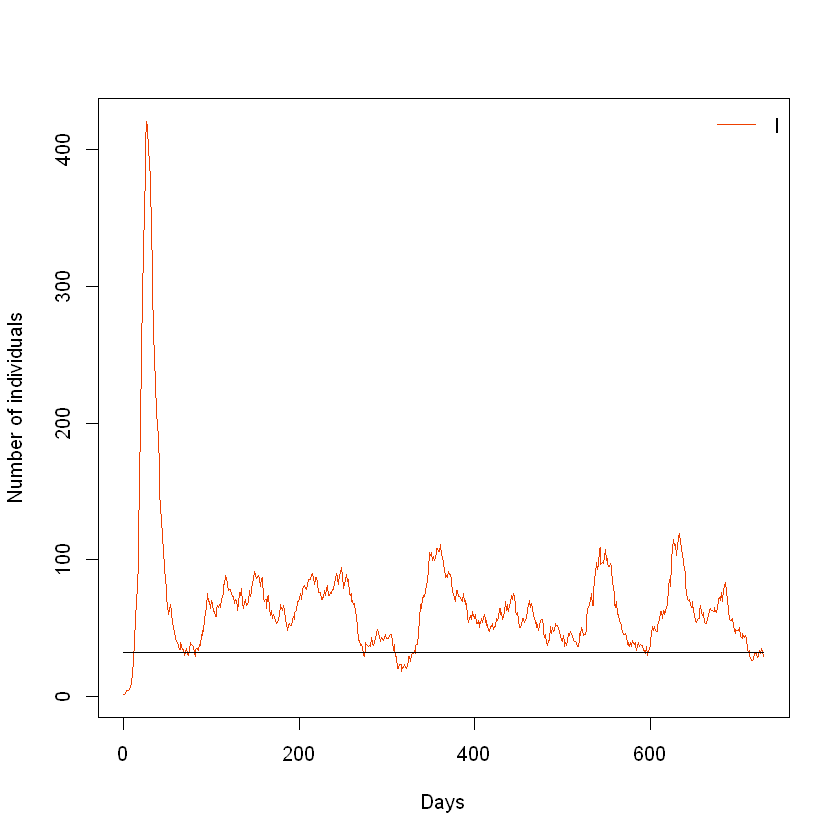

In [18]:
 # Define parameters 
    R0   <- 4 # R0  
    gamma<- 1/8 # recovery rate
    delta<- 1/90 # Immunity loss rate 
    S0   <- 1000 # Susceptible population at time 0
    I0   <- 1    # Infectious population at time 0

        
    # Create a model object "sir" with the defined parameters   
    sir <- sir_generator$new(
      S_ini = S0,
      I_ini = I0,
      R0    = R0,
      gamma = gamma,
      delta = delta)

    # Set the seed for radom number generation (R standard)
    set.seed(1)

    # Run our SIR model for a period of two years (in day steps)
    t_end<- 365 * 2
    sir_res <- sir$run(0:t_end)

    # Define a threshold

    Y_limit <- sqrt(1001) # Hint look at lecture slides for how 

    #Plot our model

    sir_col <- c("Navyblue", "orangered2", "darkgreen") # Plot colours

    days <- sir_res[, 1] # define time vector for our plot 

    matplot(days, sir_res[, 3], xlab = "Days", ylab = "Number of individuals",
            type = "l", col = "orangered2", lty = 1)
    lines(c(0,365*2),c(Y_limit,Y_limit), col="black")
    legend("topright", lwd = 1, col = "Orangered2", legend = c("I"), bty = "n")


6.  Using an R0=2, can you modify the value of delta, to assume a mean immunity loss of 1 year? What do you observe, and can you explain why such behavior?

    **Answer: The immunity loss of 1 year is too long to sustain a susceptible population big enough to give rise to a new epidemic peak.**

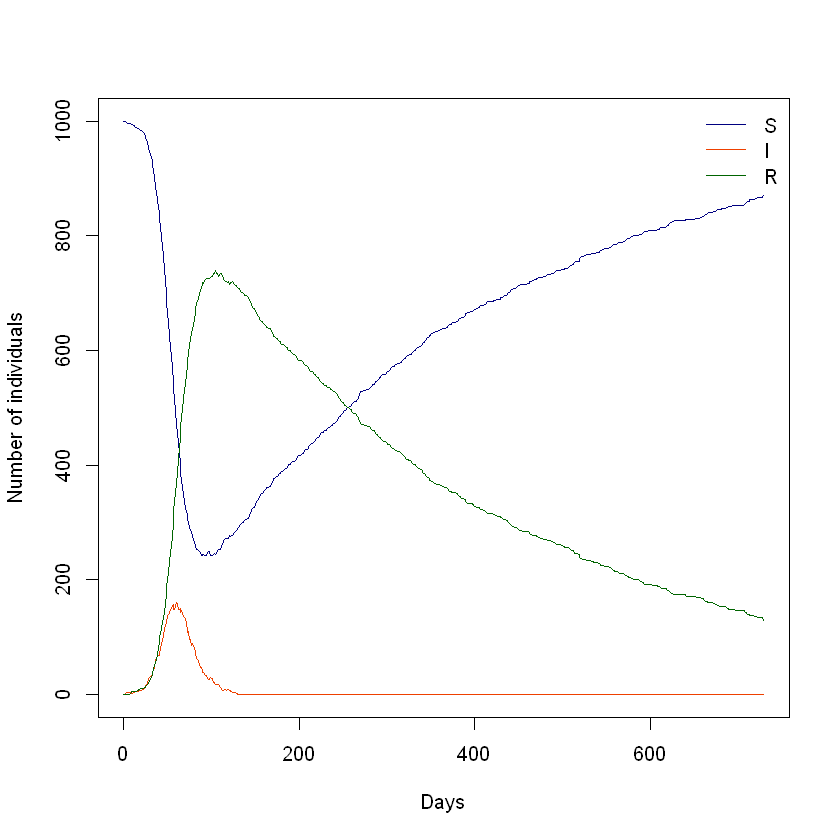

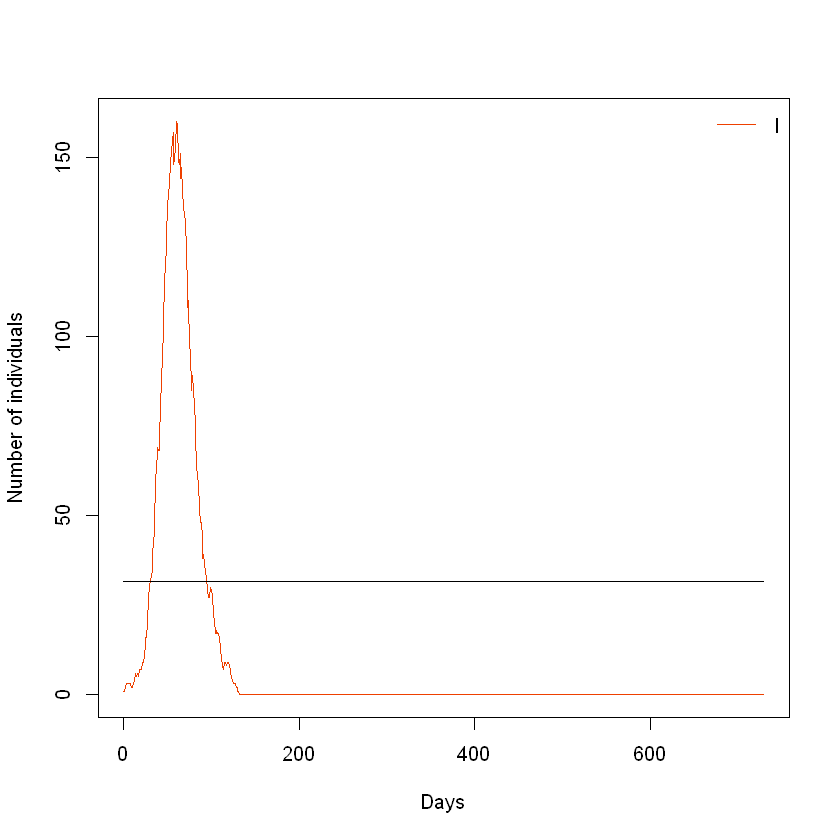

In [19]:
# Define parameters 
    R0   <- 2 # R0  
    gamma<- 1/8 # recovery rate
    delta<- 1/365 # Immunity loss rate 
    S0   <- 1000 # Susceptible population at time 0
    I0   <- 1    # Infectious population at time 0

        
    # Create a model object "sir" with the defined parameters   
    sir <- sir_generator$new(
      S_ini = S0,
      I_ini = I0,
      R0    = R0,
      gamma = gamma,
      delta = delta)

    # Set the seed for radom number generation (R standard)
    set.seed(1)

    # Run our SIR model for a period of two years (in day steps)
    t_end<- 365 * 2
    sir_res <- sir$run(0:t_end)

    #plot
    sir_col <- c("Navyblue", "orangered2", "darkgreen") # Plot colours

    days <- sir_res[, 1] # define time vector for our plot 

    matplot(days, sir_res[, -1], xlab = "Days", ylab = "Number of individuals",
            type = "l", col = sir_col, lty = 1)
    legend("topright", lwd = 1, col = sir_col, legend = c("S", "I", "R"), bty = "n")



    # Define a threshold

    Y_limit <- sqrt(1001) # Hint look at lecture slides for how 

    #Plot our model

    sir_col <- c("Navyblue", "orangered2", "darkgreen") # Plot colours

    days <- sir_res[, 1] # define time vector for our plot 

    matplot(days, sir_res[, 3], xlab = "Days", ylab = "Number of individuals",
            type = "l", col = "orangered2", lty = 1)
    lines(c(0,365*2),c(Y_limit,Y_limit), col="black")
    legend("topright", lwd = 1, col = "Orangered2", legend = c("I"), bty = "n")


We can use another feature of the *odin* package to run many simultaneous realizations of our model at once.

7.  In the code below we will run our model 100 times and plot its results (before running, set the model back to R0=2 and immunity loss to 90 days)

In [20]:
# Define parameters 
R0   <- 2 # R0  
gamma<- 1/8 # recovery rate
delta<- 1/90 # Immunity loss rate 
S0   <- 1000 # Susceptible population at time 0
I0   <- 1    # Infectious population at time 0

    
# Create a model object "sir" with the defined parameters   
sir <- sir_generator$new(
  S_ini = S0,
  I_ini = I0,
  R0    = R0,
  gamma = gamma,
  delta = delta)

# Set the seed for radom number generation (R standard)
set.seed(1)

# Run our SIR model for a period of two years (in day steps)
t_end<- 365 * 2
sir_res <- sir$run(0:t_end)

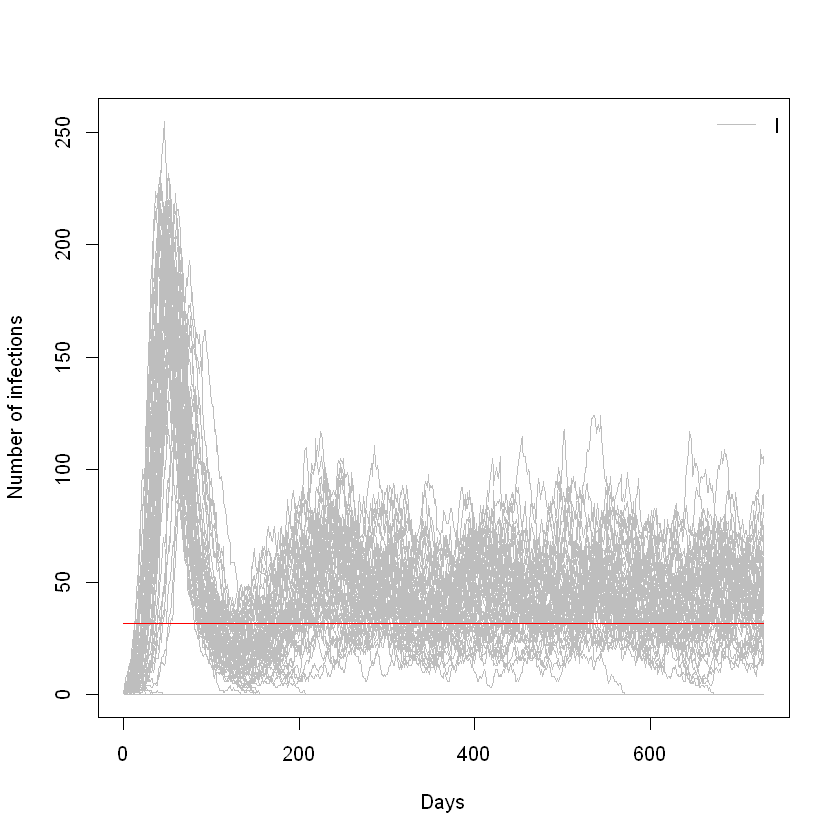

In [21]:
# Use the replicate to repeat our model run 100 times
sir_100 <- sir$run(0:t_end, replicate = 100)
# res_200 <- sir$transform_variables(res_200)
# res_200 <- cbind.data.frame(t = res_200[[1]], res_200[-1])

matplot(sir_100[, 1,],sir_100[, 3,], xlab = "Days", ylab = "Number of infections",
        type = "l", lty = 1, col="grey")
lines(c(0,t_end),c(Y_limit,Y_limit),type="l", col="red") 
legend("topright", lwd = 1, col = "grey", legend = c("I"), bty = "n")


Given that we have a number of replicates or simulations for the same model we could estimate a probability of epidemic extinction for the current model parameters. We can do it by looking how many of those Infections trajectories are equal to zero at the end of the simulation time.

8.  Use the code below to estimate probability of extinction.
9.  Change your model parameters to R0=4.5 and the to R0 = 1 and re estimate this value

In [22]:
# Here we create a user defined function to find p. extinction
prob_extinct<-function(results,t_end){
  
  n_extinct<-length(which(results[t_end,3,]==0)) # find simulations ending in zero
  n_runs   <-length(results[1,1,])
  
  return(prob_extinction=n_extinct/n_runs) 
}

# call the newly defined function, passing our model results object and time length
prob_extinct(sir_100,t_end)

[1] 0.49

**Answer: For R0=4.5 the extinction probability is \~19%**

[1] 0.19

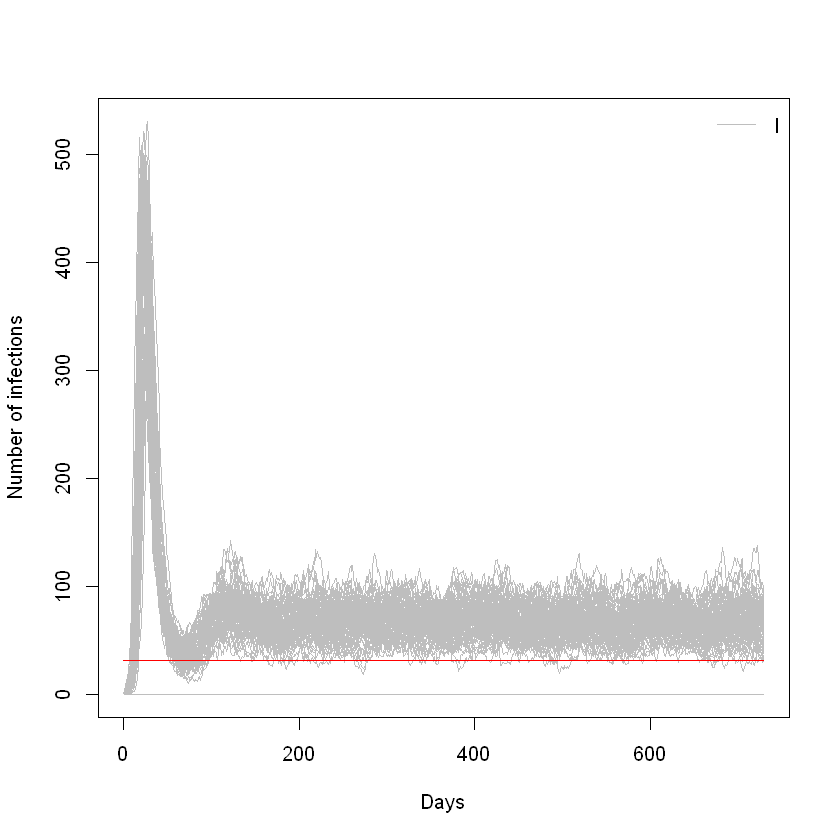

In [23]:
# Define parameters 
R0   <- 4.5 # R0  
gamma<- 1/8 # recovery rate
delta<- 1/90 # Immunity loss rate 
S0   <- 1000 # Susceptible population at time 0
I0   <- 1    # Infectious population at time 0

    
# Create a model object "sir" with the defined parameters   
sir <- sir_generator$new(
  S_ini = S0,
  I_ini = I0,
  R0    = R0,
  gamma = gamma,
  delta = delta)

# Set the seed for radom number generation (R standard)
set.seed(1)

# Run our SIR model for a period of two years (in day steps)
t_end<- 365 * 2
sir_res <- sir$run(0:t_end)
# Use the replicate to repeat our model run 100 times

sir_100 <- sir$run(0:t_end, replicate = 100)
# res_200 <- sir$transform_variables(res_200)
# res_200 <- cbind.data.frame(t = res_200[[1]], res_200[-1])

matplot(sir_100[, 1,],sir_100[, 3,], xlab = "Days", ylab = "Number of infections",
        type = "l", lty = 1, col="grey")
lines(c(0,t_end),c(Y_limit,Y_limit),type="l", col="red") 
legend("topright", lwd = 1, col = "grey", legend = c("I"), bty = "n")

prob_extinct(sir_100,t_end)

**Answer: For R0=1 the extinction probability is \~100%**

[1] 1

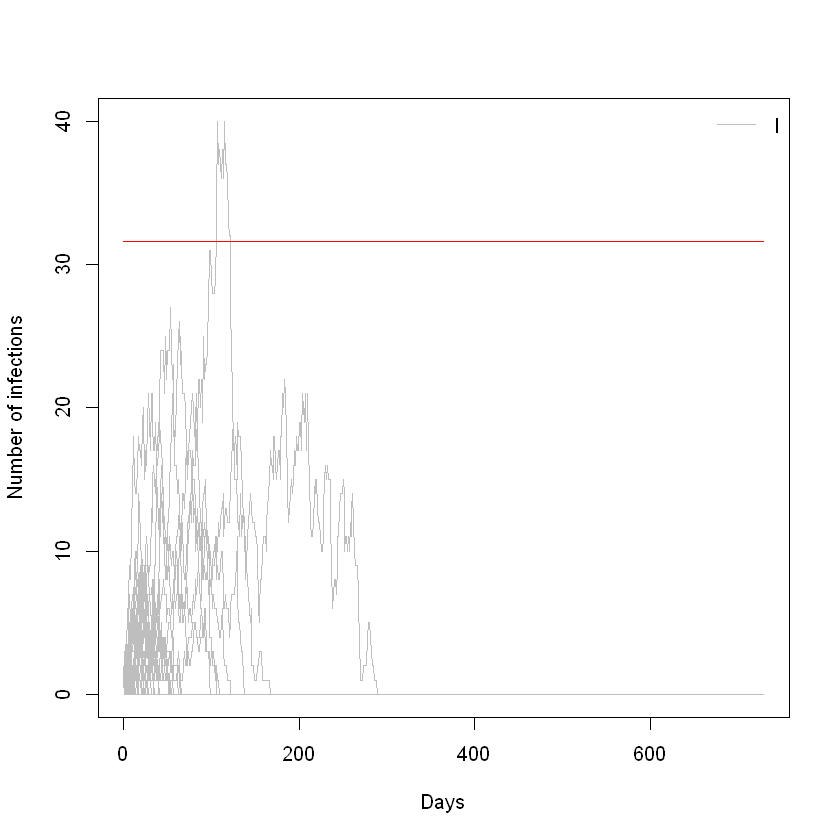

In [24]:
# Define parameters 
R0   <- 1 # R0  
gamma<- 1/8 # recovery rate
delta<- 1/90 # Immunity loss rate 
S0   <- 1000 # Susceptible population at time 0
I0   <- 1    # Infectious population at time 0

    
# Create a model object "sir" with the defined parameters   
sir <- sir_generator$new(
  S_ini = S0,
  I_ini = I0,
  R0    = R0,
  gamma = gamma,
  delta = delta)

# Set the seed for radom number generation (R standard)
set.seed(1)

# Run our SIR model for a period of two years (in day steps)
t_end<- 365 * 2
sir_res <- sir$run(0:t_end)
# Use the replicate to repeat our model run 100 times

sir_100 <- sir$run(0:t_end, replicate = 100)
# res_200 <- sir$transform_variables(res_200)
# res_200 <- cbind.data.frame(t = res_200[[1]], res_200[-1])

matplot(sir_100[, 1,],sir_100[, 3,], xlab = "Days", ylab = "Number of infections",
        type = "l", lty = 1, col="grey")
lines(c(0,t_end),c(Y_limit,Y_limit),type="l", col="red") 
legend("topright", lwd = 1, col = "grey", legend = c("I"), bty = "n")

prob_extinct(sir_100,t_end)